In [74]:
import sys
import pickle
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
tf.disable_v2_behavior()
import PIL.Image
%matplotlib inline
import matplotlib.pyplot as plt

##### Set the path to directory containing code of this case

In [75]:
new_path = 'C:\\Users\\Windows\\Documents\\LTrace\\GeoModeling_GANSim-2D_Condition_to_Well_Facies_and_Global_Features\\Code\\1_conditioning_to_well_facies_alone_or_with_global_features\\'
sys.path.append(new_path)

#### Set the path to data directory; this directory includes two datasets: "trainingdata" and "testdata"

In [76]:
data_dir_test = 'C:\\Users\\Windows\\Documents\\LTrace\\GeoModeling_GANSim-2D_Condition_to_Well_Facies_and_Global_Features\\TrainingData\\'

#### Set path to trained network

In [77]:
# 19200 means totally 19200 thousand training images (facies models) used for the training
network_dir = 'C:\\Users\\Windows\\Documents\\LTrace\\GeoModeling_GANSim-2D_Condition_to_Well_Facies_and_Global_Features\\TrainingResults\\3_GANs conditioned to sinuosity gf and well facies\\099-pgan-cond-Well-sinuosity-2gpu\\'
network_name = 'network-snapshot-025920.pkl'

### 1. Fetch dataset

In [78]:
# Initialize TensorFlow session.
tf.InteractiveSession()

import dataset
# tfrecord_dir='TestData' to fetch test dataset, if tfrecord_dir='TrainingData' to fetch training dataset
# labeltypes: 0 for 'channelorientation', 1 for 'mudproportion', 2 for 'channelwidth', 3 for 'channelsinuosity'
# well_enlarge: if True, well points occupy 4x4 area, otherwise occupy 1x1 area
test_set = dataset.load_dataset(data_dir=data_dir_test, verbose=True, tfrecord_dir='TestData', labeltypes = [1,2,3], well_enlarge = True, shuffle_mb = 0, prefetch_mb = 0)

# labels are from -1 to 1
image_test, label_test = test_set.get_minibatch_imageandlabel_np(3000)
probimg_test, wellfacies_test = test_set.get_minibatch_probandwell_np(3000*8)


Streaming data using dataset.TFRecordDataset...
Dataset shape = [1, 64, 64]
Dynamic range = [0, 255]
Label size    = 3


In [79]:
print(image_test.shape)
print(label_test.shape)
print(probimg_test.shape)
print(wellfacies_test.shape)

(3000, 1, 64, 64)
(3000, 3)
(24000, 1, 64, 64)
(24000, 1, 64, 64)


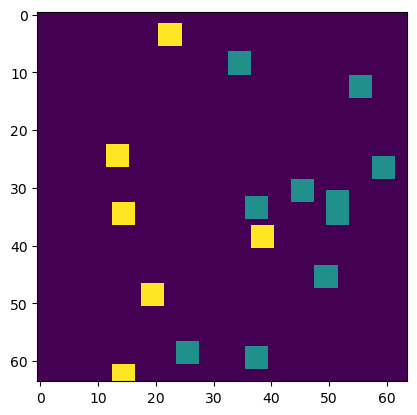

In [80]:
plt.imshow(wellfacies_test[55,0])

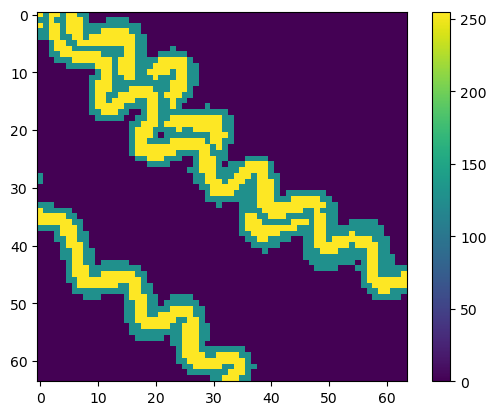

In [81]:
plt.imshow(image_test[60,0])
plt.colorbar()

#### Global features are kept and inputted into Networks with the scale of -1 to 1. To recover the global features into its original scales, use the below transformation functions.


In [82]:
# index in label_test[:,0], e.g., "0" here, needs to be adjusted according to the setting of "labeltypes = [3]" in previous "dataset.load_dataset(..)" function

#orit_test = (label_test[:,0]/2+0.5)*168-84
back_ratio_test = (label_test[:,0]/2+0.5)*0.8037109375+0.167724609375
width_test = (label_test[:,1]/2+0.5)*0.8+2.7
amwv_ratio_test = (label_test[:,2]/2+0.5)*0.4866197183098592+0.06338028169014084

### 2. Import pre-trained Network

In [83]:
# Initialize TensorFlow session.
tf.InteractiveSession()

# Import networks.
with open(network_dir+network_name, 'rb') as file:
    G, D, Gs = pickle.load(file)


### 3. Evaluation of the imported pretrained Generator


### 3.1 Fetch 300 inputs from Test dataset

In [84]:
# Sample 300 global features, probability maps, and well facies data
faciesmodels_real = image_test[:3000]
labels_inspect = label_test[:3000]
proborder = np.arange(3000) * 8 + np.random.RandomState(32).randint(0, 8, size=3000)

wellfacies_inspect_init = wellfacies_test[proborder]
wellfacies_points_inspect = np.where(wellfacies_inspect_init>0, 1, 0)
wellfacies_facies_inspect = np.where(wellfacies_inspect_init<1.5, 0, 1)
wellfacies_inspect = np.concatenate([wellfacies_points_inspect, wellfacies_facies_inspect], 1)

In [85]:
print(labels_inspect.shape)
print(wellfacies_inspect.shape)

(3000, 3)
(3000, 2, 64, 64)


##### Create masks to only output visualize well facies against white background

In [86]:
### Enlarge areas of well points for displaying ###
wellfacies_onechannel = wellfacies_inspect[:,0:1]+wellfacies_inspect[:,1:2]
wellfacies_onechannel_mask = np.ma.masked_where(wellfacies_onechannel == 0, wellfacies_onechannel)
cmap_well = plt.cm.viridis  # Can be any colormap that you want after the cm   '.
cmap_well.set_bad(color='white')

c:\Users\Windows\anaconda3\envs\gansim\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  """


### 3.2 General visual assessment

####  Visual assessment on realism, diversity, conditioning to global features, conditioning to well facies data

* (1) Input corresponding global features with well data into trained Generator

   Second column corresponds to ground truth for well facies data and global features.

In [87]:
print(Gs.input_shapes)

[[None, 128], [None, 1], [None, 2, 64, 64]]


In [88]:
wellfacies_plt.shape

(300, 2, 64, 64)

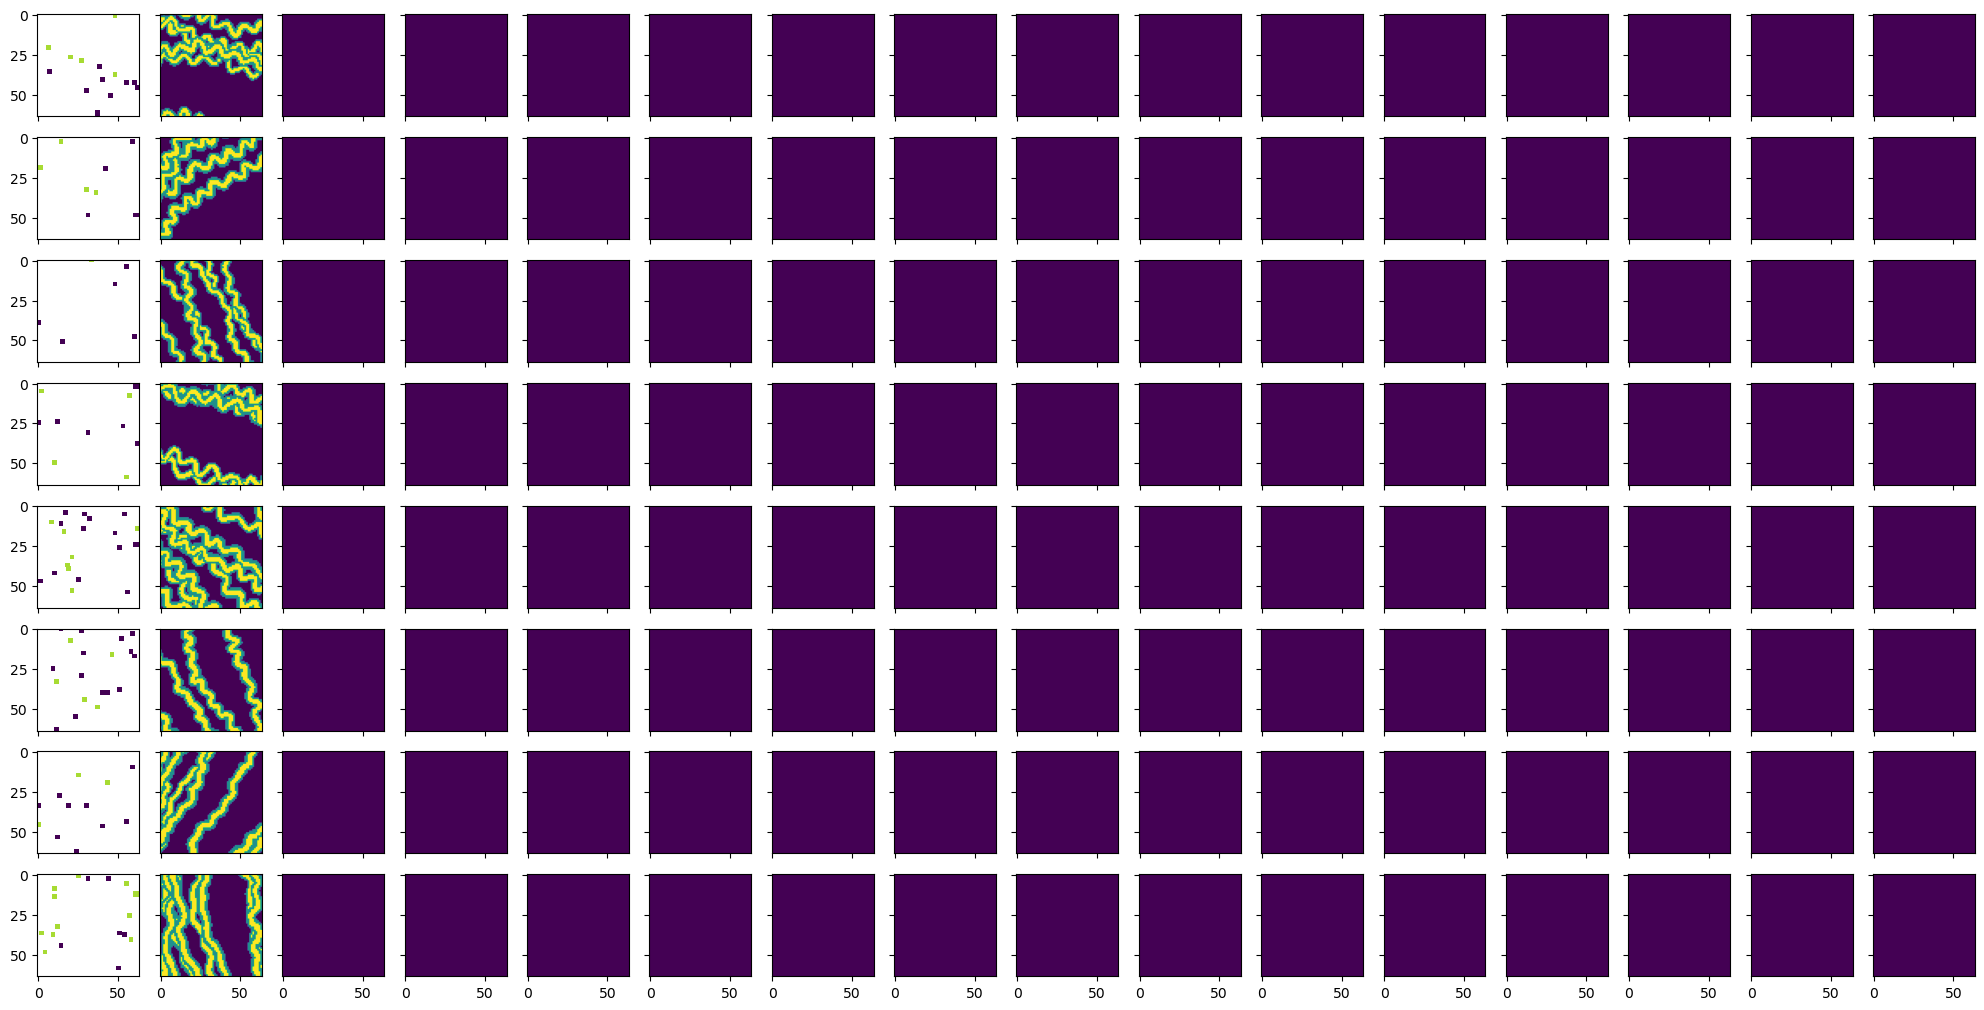

In [89]:
fig, ax = plt.subplots(8, 16, sharex='col', sharey='row')
fig.set_size_inches(25, 12.5, forward=True)

images_plt_average = np.zeros((8,1,64,64))
for i in range (8):
    
    ax[i, 0].imshow(wellfacies_onechannel_mask[i,0], cmap=cmap_well, vmax = 2.15)
    ax[i, 1].imshow(faciesmodels_real[i,0,:,:])  # *15+50 is to create inconsistency between labels and probimg
    
    latents_plt = np.random.randn(500, Gs.input_shapes[0][1])
    labels_plt = np.repeat(np.expand_dims(labels_inspect[i,2:3], axis=0), 500, axis=0)  ##
    wellfacies_plt = np.repeat(np.expand_dims(wellfacies_inspect[i], axis=0), 500, axis=0)
    
    images_plt = Gs.run(latents_plt, labels_plt, wellfacies_plt)
    images_plt = np.where(images_plt< -0.3, -1, images_plt)
    images_plt = np.where(images_plt> 0.3, 1, images_plt)
    images_plt = np.where((images_plt> -0.4) & (images_plt< 0.4), 0, images_plt)

    images_plt_a = (np.where(images_plt> -0.2, 1, images_plt) + 1)/2
    images_plt_average[i] = np.average(images_plt_a, axis = 0)

    for j in range(2,15):
        ax[i, j].imshow(images_plt[j-2,0,:,:])
    ax[i, 15].imshow(images_plt_average[i, 0])    
#plt.savefig(network_dir + "Random Latents.png", dpi=200) 

### 3.3 Evaluation of Generator's conditioning ability to global features

#### 3.3.1 Visual assessment by comparing to corresponding ground truth facies models.

* Generate facies models with increasing input sinuosity index 


**    Choose appropriate increasing global features from test data.  **
      These chosen global features will be used to simulate facies models; these facies models will be compared to ground truth facies models with the same global features in test dataset
      

**    Choose appropriate increasing global features from test data.  **

In [90]:
amwv_ratio_no = 4

In [91]:
amwv_ratio_test_max = np.max(amwv_ratio_test)
amwv_ratio_test_min = np.min(amwv_ratio_test)
plot_img_no = np.empty((amwv_ratio_no), dtype = np.int)
for j in range(amwv_ratio_no):
    for r in range(amwv_ratio_test.shape[0]):
        if amwv_ratio_test[r] >= (amwv_ratio_test_max - amwv_ratio_test_min) * j/amwv_ratio_no+amwv_ratio_test_min and \
        amwv_ratio_test[r] < (amwv_ratio_test_max - amwv_ratio_test_min) * (j+1)/amwv_ratio_no+amwv_ratio_test_min and \
        back_ratio_test[r] >= 0.5 and back_ratio_test[r] <0.6:
            plot_img_no[j] = r
            break

In [92]:
print(plot_img_no)

[ 6  2 18  0]


##### Simulate with the above chosen appropriate global features

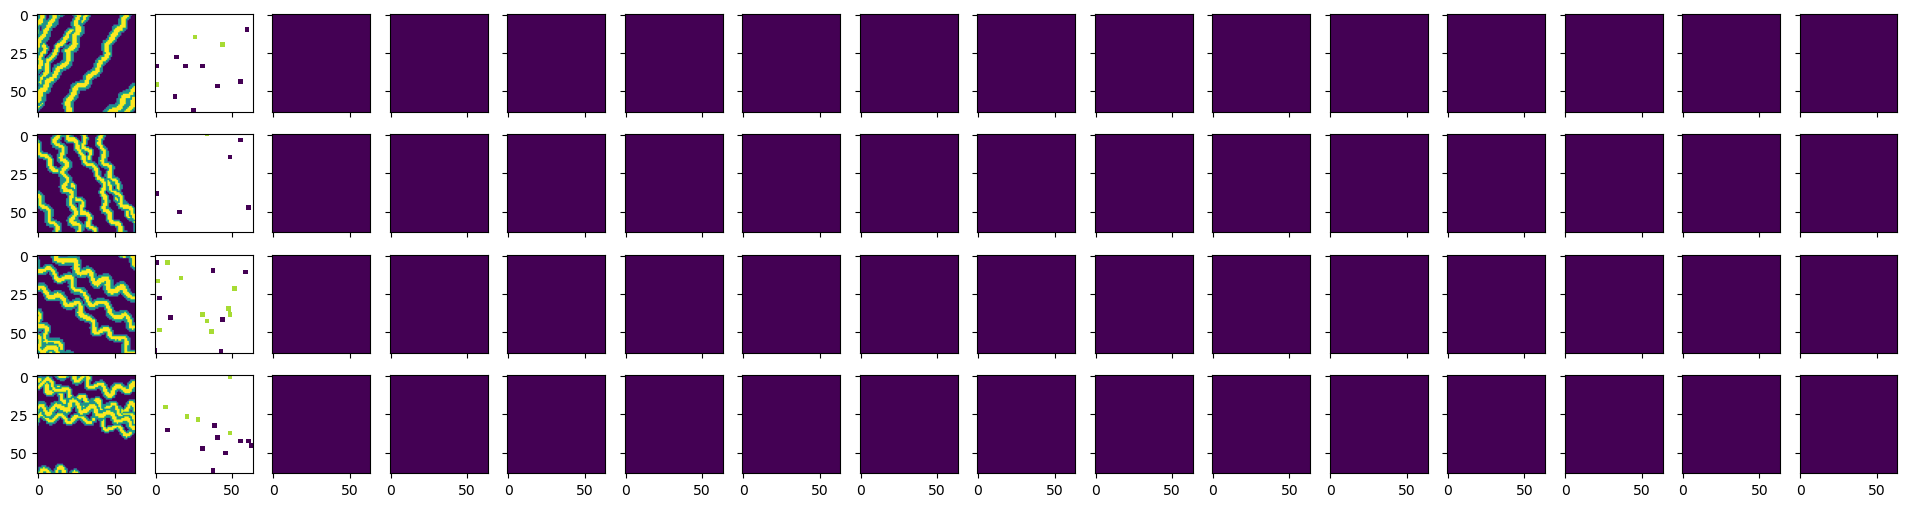

In [93]:
# This cell is only used for evaluation of conditioning to sinuosity when the GAN is only conditioning to sinuosity and well facies data
fig, ax = plt.subplots(4, 16, sharex='col', sharey='row')
fig.set_size_inches(24, 6, forward=True)

images_plt_average = np.zeros((4,1,64,64))
images_plt_variance = np.zeros((4,1,64,64))
for i in range (4):
    gt_no = plot_img_no[i]
    ax[i, 0].imshow(faciesmodels_real[gt_no,0,:,:]) 
    ax[i, 1].imshow(wellfacies_onechannel_mask[gt_no,0], cmap=cmap_well, vmax = 2.15)
    
    latents_plt = np.random.randn(500, Gs.input_shapes[0][1])
    labels_plt = np.repeat(np.expand_dims(labels_inspect[gt_no,2:3], axis=0), 500, axis=0)  # labels_inspect was given arguments [gt_no, 3:4], but the actual array has (3000,3) dimensions, thus 2:3
    wellfacies_plt = np.repeat(np.expand_dims(wellfacies_inspect[gt_no], axis=0), 1 * 500, axis=0)
    
    images_plt = Gs.run(latents_plt, labels_plt, wellfacies_plt)
    images_plt = np.where(images_plt< -0.3, -1, images_plt)
    images_plt = np.where(images_plt> 0.3, 1, images_plt)
    images_plt = np.where((images_plt> -0.4) & (images_plt< 0.4), 0, images_plt)

    images_plt_a = np.where(images_plt> -0.3, 1, 0)
    
    images_plt_average[i] = np.average(images_plt_a, axis = 0)
    images_plt_variance[i] = np.var(images_plt_a, axis = 0)

    for j in range(2,14):
        ax[i, j].imshow(images_plt[j-2,0,:,:])
    ax[i, 14].imshow(images_plt_average[i, 0], vmin = 0, vmax = 1) 
    ax[i, 15].imshow(images_plt_variance[i, 0], vmin = 0, vmax = 0.25)
plt.savefig(network_dir + "Condition to sinuosity1.png", dpi=200) 

In [94]:
print(plot_img_no)
print(amwv_ratio_test[plot_img_no])

[ 6  2 18  0]
[0.07       0.22999999 0.38016528 0.55      ]


#### 3.3.2 Quantitative assessment by comparing to corresponding ground truth facies models.
#### *  Assess channel sinuosity
#### Second quantitative evaluation method in paper.
##### 1) With input global features from test dataset, generate a number of facies model realizations;
##### 2) Use image process toolbox in Matlab to measure the channel sand sinuosity for each generated facies model and the real facies model in test dataset;
##### 3) Use blox plot to compare the distribution of calculated global features from the generated facies models and the real facies models from test dataset.


In [95]:
latents_plt = np.random.RandomState(99).randn(300, Gs.input_shapes[0][1])
labels_plt = label_test[:300, 2:3]
wellfacies_plt = wellfacies_inspect[:300]

# Run the generator to produce a set of images.
images_plt = Gs.run(latents_plt, labels_plt,wellfacies_plt)
images_plt = np.where(images_plt< -0.3, -1, images_plt)
images_plt = np.where(images_plt> 0.3, 1, images_plt)
images_plt = np.where((images_plt> -0.4) & (images_plt< 0.4), 0, images_plt)

In [96]:
# Save the generated facies models to measure their global features in Matlab

np.savetxt(network_dir + 'images_generated.out', np.reshape(images_plt,[-1,64]), delimiter='\n', fmt='%1.1e')   # X is an array
np.savetxt(network_dir + 'input_sinuosity.out', amwv_ratio_test[:300], delimiter=',', fmt='%1.4e')

In [97]:
# Calculate corresponding mud facies proportion, used for falsification
props = np.average(np.where(images_plt < -0.5, 1, 0), axis = (1, 2, 3))
np.savetxt(network_dir + 'images_generated_variouswelldata.out', props, delimiter='\n', fmt='%1.4e')   


###### Box plot

In [98]:
# statistics of generated facies models with differnt input sinuosity
atodlen1=[1.11889313640155,1.09077787644318,1.12165645035333,1.09007474127227,1.13424798563159,1.13978293428402,1.11589740130591,1.08779763348608,1.10422031446294,1.17915902056786,1.02510382912376,1.17754080734206,1.10875489964738,1.18006034468054,1.27723890880682,1.14638300311517,1.08693130776357,1.1252197699912,1.109755804729,1.16673251350461,1.06846449139615,1.17203190188304,1.16330998283785,1.0672391301468,1.08866531192593,1.12416211546016,1.08876828138484,1.13792798971085,1.08172883034534,1.21580531837135,1.16354479912917,1.08044443747823,1.10654455347437,1.10174692816356,1.15188569360076,1.1405607079217,1.18031308206105,1.18542732746059,1.1232360416386,1.08106615903648,1.03094429058473,1.09190293169268,1.11142403382545,1.16616135904274,1.10355341434478,1.16389655030855,1.16659102541762,1.13192857588692,1.07118203692042,1.1266728660161,1.07459689798195,1.09970672681694,1.10635609001926,1.13221228463309,1.11750625345516,1.14314916661737,1.20083274841309,1.20504213919236,1.18240699508685,1.08712839696534,1.2260388931612,1.12483686658524,1.13391254500886,1.11078855865792,1.1359207331302,1.22642969615047]
atodlen2=[1.23346416627969,1.18790795871182,1.13206343645113,1.15338398825942,1.35522185771154,1.25681517599675,1.25224679547042,1.29612092872378,1.24560397238837,1.1491338876045,1.25456488401029,1.23013928805078,1.19372906892008,1.22265130803079,1.21318294337388,1.28551517544856,1.25217338162324,1.10815673856744,1.14175645721712,1.20245720113621,1.26116454098179,1.23981030791812,1.10862054524809,1.19454408468376,1.26833117593655,1.17526158283443,1.3340651202328,1.20681028667095,1.28884541800114,1.29659761124924,1.17471201367372,1.2623522326848,1.27644874404882,1.27708851822535,1.20310242653192,1.20839972375883,1.2577319236707,1.19332561298605,1.19804239122632,1.27270631353138,1.15814653319549,1.17790658980959,1.28400380876366,1.274688236357,1.40724325130618,1.18431519006312,1.38478713245515,1.33262839242974,1.22182427675395,1.28858043330918,1.2480230728123,1.26572099474012]
atodlen3=[1.42192410908225,1.30050392626452,1.39992573412069,1.37263802405987,1.47959767824524,1.33871582748462,1.55702586171734,1.29703136026025,1.42648817860534,1.54277708166896,1.3413078386406,1.37451623939317,1.33874745766729,1.28142160021022,1.3640579438568,1.3312281783283,1.26124791761409,1.42836951848415,1.42330129463223,1.3824873212986,1.32318867234402,1.34780962028487,1.46170292845754,1.40062567956459,1.34601323608999,1.2991542394207,1.39879432768685,1.35982398566578,1.38103394691446,1.46038873239369,1.3695438754174,1.32504218975231,1.38660499687224,1.52656655308705,1.46086932069164,1.39252518413149,1.32385365329999,1.49312453883924,1.48530704668984,1.38268800710165,1.50227513995371,1.40363340757143,1.43564719222004,1.30066577684531,1.38946521505559,1.35515484785891,1.35373208958743,1.48410146998181,1.55720364978457]
atodlen4=[1.47854052910486,1.44875296985827,1.56205549619363,1.49967116076352,1.5110593576732,1.54660190884447,1.61775808590815,1.63299484355889,1.44380133543288,1.8768958182758,1.51801322831438,1.66702979671336,1.58709698671153,1.51647210762613,1.43256584267425,1.63567708346971,1.67397299546274,1.7805802368729,1.49779277041385,1.7116209119977,1.69743132669584,1.54304168767851,1.50029133424245,1.43418602408524,1.64933702557829,1.68593331031236,1.46346597383482,1.59628920777078,1.4938495366634,1.5193055744107,1.77318391930879,1.51501375015756,1.66865709073917,1.57122626158941,1.38764347641693,1.52438039615829,1.69678134962763,1.47333633645482,1.60123019487691,1.46272626757244,1.63630072740957,2.09612413473267,1.82043738987135,1.76016424252416,1.70838436718918,1.61712018873247,1.52252092436247,1.60551035800042,1.70797328069314,1.61350523799317,1.51520291640211,1.51784056099423,1.50671388504789,1.58125653505074,1.46183724432156,1.75201099012403,1.50460566587645,1.32495784759522,1.63960059500893,1.83595874370741,1.62801633133348,1.31987552398628,1.91973429586026,1.53907450403085,1.33521982648562,1.52347521729374,10.3066484298083,1.4467062138431,1.38666242910265,1.60423843720179,1.53993290339551,1.74443934718012,1.45756769539599,1.55009632415411,1.3521773223474,1.43932014186439,1.46019141523122,1.58652908035827,1.66918275044889,1.6224014047749,1.39148723365835,1.52729178631895,1.89642724630959,1.56554835652658,1.82062181678182,1.4529929845647,1.77689702994759,1.59889335828939,1.61332230786664,2.05694321876533,1.44468123769683,1.49215293366155,1.44791406892582,1.64402865035875,1.54780224110627,1.63894827288451,5.22306304558851,1.53235259488324,1.37752366585505,1.51948863864103,1.70012307970306,1.62365146804077,1.5619331999111,1.64510583463559,1.5848142375346,1.49508528589155,1.42645082603477,1.460990268011,2.01645794711342,1.40852830991425,1.57794744143376,1.25163213782414,1.55399420643523,1.44450010301215,1.47066214824339,1.7198627187404,1.48373251955428,1.57968195253227,1.59452089774149,1.68339687365707,1.51820707428025,1.46864477882538,1.62361567367562]


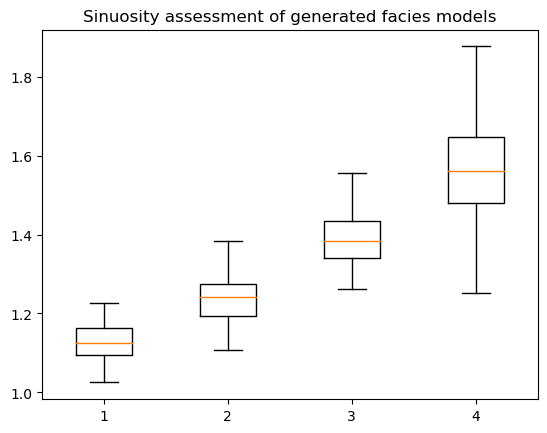

In [99]:
fig1, ax1 = plt.subplots()
ax1.set_title('Sinuosity assessment of generated facies models')
ax1.boxplot([atodlen1,atodlen2,atodlen3,atodlen4],showfliers=False)
plt.savefig(network_dir + "Sinuosity assessment of generated facies models.png", dpi=200)   

### 3.4 Evaluation of Generator's conditioning ability to input well data

**Well points accuracy evaluation**

In [100]:
def get_random_well_facies_data(images_num):
    well_points = np.zeros([images_num, 1, 64, 64], dtype = int)
    for i in range(images_num):
        well_points_num = np.random.RandomState(3*i).choice(np.arange(8, 16), 1)  # Random choose the expected total number of well points
        xs = np.random.choice(64, well_points_num)
        ys = np.random.choice(64, well_points_num)
        well_points[i, 0, xs, ys] = 1

    # Using test facies models to sample faices types at well  points
    well_facies = np.where(well_points * image_test[:images_num]>0, 1, 0)
    well_facies = np.concatenate([well_points, well_facies], 1)      
 
    return well_facies

In [101]:
def generate_images(realization_num, well_facies):
    # Generate latent vectors.
    latents_plt = np.random.randn(realization_num, Gs.input_shapes[0][1]) 
    labels_plt =  np.random.uniform(-1, 1, (realization_num, Gs.input_shapes[1][1])) 
    well_facies_plt = well_facies

    # Run the generator to produce a set of images.
    images_plt = Gs.run(latents_plt, labels_plt, well_facies_plt)
    images_plt = np.where(images_plt< -0.3, -1, images_plt)
    images_plt = np.where(images_plt> 0.15, 1, images_plt)
    images_plt = np.where((images_plt>= -0.3) & (images_plt<= 0.15), 0, images_plt)
    return images_plt

In [102]:
def well_points_accuracy(well_facies, fake_imgs_a):
    gg = well_facies_smp_train_facies[:,0:1] + well_facies_smp_train_facies[:,1:2]
    
    recognized_f1 = np.where((gg==2) & (well_facies_smp_train_facies[:,0:1] * (fake_imgs_a+1) > 0.8), 1, 0)
    f1_prob = np.sum(recognized_f1)/np.sum(np.where(gg==2,1,0))

    recognized_f0 = np.where((gg==1) & (well_facies_smp_train_facies[:,0:1] * (fake_imgs_a+2) ==1), 1, 0)
    f0_prob = np.sum(recognized_f0)/np.sum(np.where(gg==1,1,0))
    
    return f1_prob, f0_prob

In [103]:
def enlarge(well_facies):
    ### Enlarge areas of well points into 4 x 4 as inputs
    with tf.device('/gpu:0'):
        well_facies = tf.cast(well_facies, tf.float32)
        well_facies_enlarge = tf.nn.max_pool(well_facies, ksize = [1,1,4,4], strides=[1,1,1,1], padding='SAME', data_format='NCHW') 
    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        well_points_el = sess.run(well_facies_enlarge) 
    return well_points_el

In [104]:
images_num = 100
well_facies_smp_train_facies = get_random_well_facies_data(images_num)
well_facies_smp_train_facies_el = enlarge(well_facies_smp_train_facies)      
fake_imgs = generate_images(images_num, well_facies_smp_train_facies_el)
f_c_prob, f_m_prob = well_points_accuracy(well_facies_smp_train_facies, fake_imgs)
print(f_c_prob) # well facies reproduction accuracy for input channel complex facies
print(f_m_prob) # well facies reproduction accuracy for input mud facies

0.0020325203252032522
0.9924698795180723


###  4. Evaluation of the imported pretrained Discriminator as a global feature recognizer

#### Assess D with Test data

In [105]:
plt_data_no = 500
a = np.arange(plt_data_no)
np.random.shuffle(a)
test_img_no = a[:plt_data_no]
_, features = D.run(image_test[test_img_no]/127.5-1)

y=-0.005130x+(0.490807)


Text(0, 0.5, 'Predicted amplitude/wavelength ratio by D')

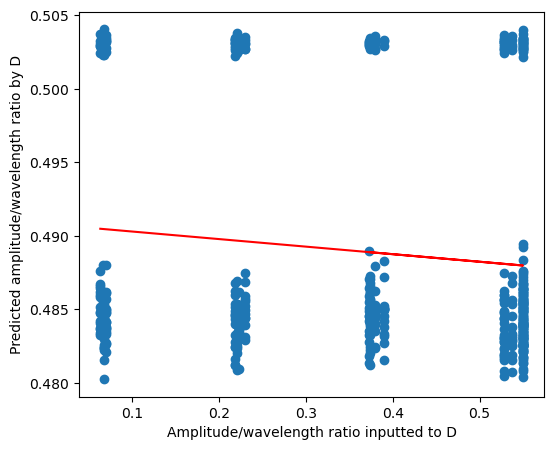

In [106]:
# orit_test = (label_test[:,0]/2+0.5)*168-84
# back_ratio_test = (label_test[:,1]/2+0.5)*0.8037109375+0.167724609375
# width_test = (label_test[:,2]/2+0.5)*0.8+2.7
# amwv_ratio_test = (label_test[:,3]/2+0.5)*0.4866197183098592+0.06338028169014084

features[:, 0] = (features[:, 0] /2+0.5)*0.4866197183098592+0.06338028169014084

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 5, forward=True)

# labels_cor includes: orientation, background_ratio, width, amplitude/wavelength ratio, after shifting to (-1, 1)
ax.scatter(amwv_ratio_test[test_img_no], features[:, 0]) 
# calc the trendline
z3 = np.polyfit(amwv_ratio_test[test_img_no], features[:, 0], 1)
p3 = np.poly1d(z3)
ax.plot(amwv_ratio_test[test_img_no],p3(amwv_ratio_test[test_img_no]),"r-")
# the line equation:
print ("y=%.6fx+(%.6f)"%(z3[0],z3[1]))
ax.set_xlabel("Amplitude/wavelength ratio inputted to D")
ax.set_ylabel("Predicted amplitude/wavelength ratio by D")
#plt.savefig(network_dir +"Mud facies ratio scatter of fake vs real.png", dpi=200)   


#### Assess D with Simulated data
*(1) Randomly Select global features data

In [107]:
print(plt_data_no)

500


In [108]:
# Generate latent vectors.
latents_plt = np.random.randn(plt_data_no, Gs.input_shapes[0][1]) # 1000 random latents *Gs.input_shapes[0][1:]=[None, 128] [None, 4]

labels_plt = labels_inspect[:plt_data_no, 2:3]

wellfacies_plt = wellfacies_inspect[:plt_data_no]

# Run the generator to produce a set of images.
images_plt = Gs.run(latents_plt, labels_plt, wellfacies_plt)
images_plt = np.where(images_plt< -0.7, -1, images_plt)
images_plt = np.where(images_plt> 0.3, 1, images_plt)

_, features = D.run(images_plt)


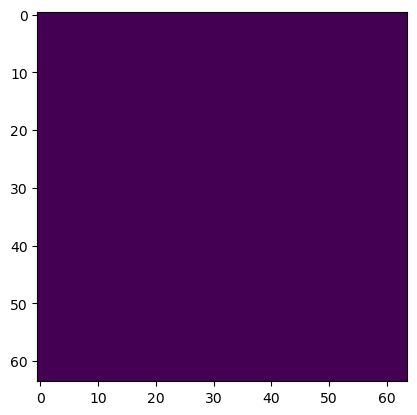

In [109]:
plt.imshow(images_plt[0,0])

y=0.000889x+(0.487898)


Text(0, 0.5, 'Predicted amplitude/wavelength ratio by D')

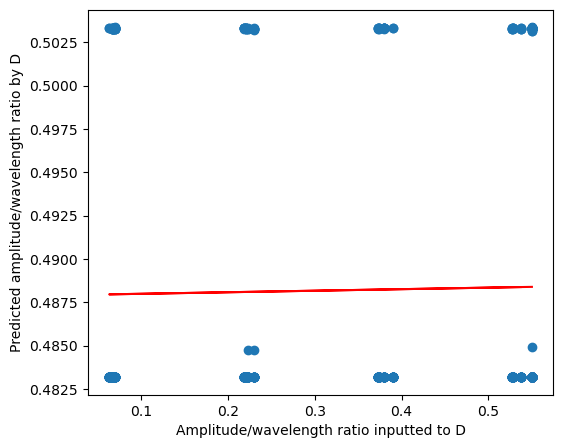

In [110]:
features[:, 0] = (features[:, 0] / 2 + 0.5) *0.4866197183098592+0.06338028169014084

labels_plt[:, 0] = (labels_plt[:, 0] / 2 + 0.5) *0.4866197183098592+0.06338028169014084


fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 5, forward=True)


# labels_cor includes: orientation, background_ratio, width, amplitude/wavelength ratio, after shifting to (-1, 1)
ax.scatter(labels_plt[:, 0], features[:, 0]) 
# calc the trendline
z3 = np.polyfit(labels_plt[:, 0], features[:, 0], 1)
p3 = np.poly1d(z3)
ax.plot(labels_plt[:, 0],p3(labels_plt[:, 0]),"r-")
# the line equation:
print ("y=%.6fx+(%.6f)"%(z3[0],z3[1]))
ax.set_xlabel("Amplitude/wavelength ratio inputted to D")
ax.set_ylabel("Predicted amplitude/wavelength ratio by D")
#plt.savefig(network_dir +"Mud facies ratio scatter of fake vs real.png", dpi=200)   